# Genetic Algorithms With Pareto Fronts

<img src="https://i.pinimg.com/originals/1a/5c/a8/1a5ca8373a83e8e84f8f268ee3ecf1de.png" width=700>


This notebook may be used in Google Colab. To access press this button:    
<a href="https://bit.ly/genetic-algorithm-colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="First: Open In Colab"/></a>

Here you will learn about implementing Pareto Optimisation with a Genetic Algorithm.  

This notebook follows the previous one in which we learned about the fundamentals of Pareto Fronts, where we examined the Knapsack problem in an exhaustive search space ([Github](https://bit.ly/pareto-front), [Google Colab](https://bit.ly/pareto-front-colab)). Here we will learn to apply in a search space that is computationally large.  

Most real life situations involve search spaces that are intractable, meaning that we might never have enough computational power to access all of the feasible solutions (baring from introduction of quantum computing). One approach is to search in a stochastic (random) manner. Not completely random, though, we would like to both exploit what we know works as well as explore new regions in the Decision and Objective spaces.  

To this end we will define and use the Genetic Algorithm as our stochastic search mechanism of choice, where Pareto Fronts are used as its *Selection Function* as detailed below. 

**Main Take Aways**  
* In large combinatorial spaces we are not likely to have access to all the feasible solutions, and need to resort to subsets as proxies.
* The difference between the ***true Pareto front*** of all feasible solutions and ***Pareto front approximations*** of subset solutions.         
* ***Niching*** generates a better ***diversity*** of solutions resulting in a better Pareto approximation.  
* The basics of Genetic Algorithms with an emphasis on Pareto fronts as the selection function.   
* You will see how the Genetic Algorithm learns by tracking the evolution of the Pareto front approximations.


**The Knapsack Problem**   
As in the previous notebook, in this challenge you will fill virtual knapsacks with packages that have monetary value and weight.   
The objective is to minimise the final weight of the knapsack and maximise the total monetary value of its contents.    
(You will also be able to change the objectives from min-max to the other options: max-max and min-min, max-min.)

**Recommended Notebook Usage**

We first recommend that you be familiar with the fundamentals of Pareto fronts as introduced in the previous notebook ([Github](https://bit.ly/pareto-front), [Google Colab](https://bit.ly/pareto-front-colab)). You will notice that some conventions used there are applied here, too.

Do each of the following steps at a time and answer the summary questions to ensure that the main lessons have been understood. 

<ul>
      
<details>
        <summary>Setup, Decision & Objective Spaces</summary> 
            The data generation of packages and knapsacks is the same as before with the exception that we will explore subsets of all feasible knapsacks, due to the fact that the Decision Space may be intractable. The Objective Space and objectives are the same. 
</details>
    
<details>
        <summary>Pareto Front Approximations</summary> 
            Here you will learn how niching which improves diversity results in better Pareto front approximations.
</details>
    
<details>
        <summary>Genetic Algorithms Components</summary> 
            You will get an understanding of the different parts that make the Genetic Algorithm with an emphasis of the Pareto optimisation mechanism implemented in the selection function.
</details>
    
<details>
        <summary>Knapsack Optimisation</summary> 
            Here you will see the Genetic Algorithm learn better solutions for the Knapsack Problem while comparing results of Pareto Optimisation vs. Single Objective Optimisation.  
</details>  
    
</ul>
    
There is no need to understand every line of Python, especially in the first run! Reading the cell headers is sufficient to understand what a cell does.  It is more important to understand the text in the Markdown cells and the visuals created.  

We recommend doing the first run until the [Summary](#Summary) section as is. 
Afterwhich we recommend that you explore different types of results by modfiying the variables flagged with ***CHANGE ME!***. We list in the [Summary](#Summary) section suggested actions to take, but feel free to be creative!


<img src="https://tinyurl.com/vrdj29w9" width="700">  

**One final note for PyCon USA participants**  

Don't worry if you don't manage to to go through everything in depth during the allocated time. You will be able to access to this notebook later.

In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams['figure.figsize'] = 12, 8

# Packages 

Let's create some data!

<img src="https://uk.packsize.com/wp-content/uploads/sites/11/2015/05/wp-boxes.jpg" width=300>

Same as in the previous tutorial, here we create packages by defining for each its weight and monetary value according to a distribution.   

Parameters of interest:  
* `N_PACKAGES` - the total number packages to choose from.  
* `value_distribution_mode` - indicates the relationship between the package weight and monetary value.   
The weights are randomly distributed where: 
    * `value_distribution_mode=random` - monetary value distribution also random
    *  `value_distribution_mode=squared` - monetary value is squared that of the weights (up to some noise quantified by `noise_factor`).  
    
This will results in 
* `packages` a dictionary containing information of the `N_PACKAGES` packages.
 It has the form `{package_number: package}`, where each `package` has the form `{'weight': weight, 'value': value}`

In [3]:
seed = 3141592653 # CHANGE ME! to get a different distribution

N_PACKAGES = 20   # CHANGE ME! the total number of packages to choose from

WEIGHT_MEAN = 0.1 # CHANGE ME! the mean of the weight distribution
WEIGHT_SD = 10    # CHANGE ME! the standard deviation of the weight distribution

VALUE_MEAN = 0.1  # CHANGE ME! when value_distribution_mode='random': the mean of the monetary value distribution 
VALUE_SD = 100    # CHANGE ME! when value_distribution_mode='random': the standard deviation of the monetary value distribution 

value_distribution_mode = 'random' # CHANGE ME! options: 'random', 'squared'
noise_factor = 1./2  # CHANGE ME! when value_distribution_mode='squared': the standard deviation of the noise introduced
# ---------------

np.random.seed(seed)

weights = np.abs(np.random.normal(WEIGHT_MEAN, WEIGHT_SD, N_PACKAGES))

if 'squared' == value_distribution_mode:
    values =  weights ** 2 
    values += values * np.random.normal(0, noise_factor, len(weights))
    values = np.abs(values)
elif 'random' == value_distribution_mode:
    values = np.abs(np.random.normal(VALUE_MEAN, VALUE_SD, N_PACKAGES))

In [4]:
# packages dictionary
packages = {idx: {'weight': weights[idx], 'value': values[idx]} for idx in range(N_PACKAGES)}

{ipackage: package for ipackage, package in packages.items() if ipackage < 4}

{0: {'weight': 16.045064716419265, 'value': 122.44920604368212},
 1: {'weight': 10.257933643337433, 'value': 34.08475741925324},
 2: {'weight': 7.427142915985984, 'value': 7.3477194585976235},
 3: {'weight': 16.1061446548582, 'value': 75.21497126311662}}

Text(0.5, 1.0, 'Packages')

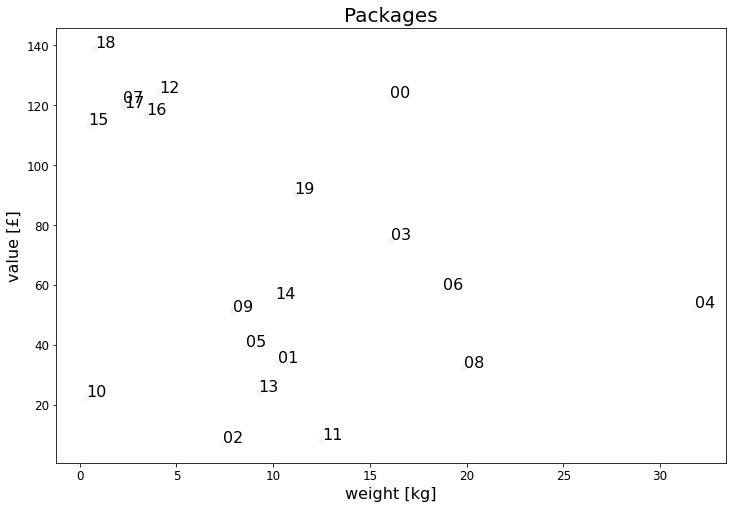

In [5]:
# visualising the package weight-value distribution

plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
            [packages[idx_package]['value'] for idx_package in packages],
            color = 'purple', alpha=0.04
           )

for idx_package, package in packages.items():
    plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=MEDIUM_SIZE)
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Packages')

#  Decision and Objective Spaces


## Decision Space Size
There are two parameters of interest that decide how many knapsacks are possible: 
* `N_PACKAGES` which was determined in [Packages](#Packages).
* `N_PACKAGES_PER_KNAPSACK` introduced here determines the number of packages that fit into a knapsack.  


We can easily calculate the number of combinations defined as an unordered arrangement of $k$ objects from a set of $n$, which is called  *$n$ choose $k$*,    
which is calculated as:  
$$
_nC_k=\frac{n!}{(n-k)!k!}\equiv {n \choose k}
$$

Here we use     
`k = N_PACKAGES_PER_KNAPSACK`  
`n = N_PACKAGES`,  
with assumptions for simplicity:  
* A package can appear only once in a a knapsack.  
* The order in which a package is assigned to a knapsack does not matter. 

**Note**  
You do not need to understand the equation above.  
Below you are provided with a calculator that executes this equation using the `math.factorial` function.    



In [6]:
from math import factorial

In [7]:
def pretty_int(x):
    if x > 1.e6:
        return f'{int(x):0.1e}'
    else:
        return f'{int(x):,}'

N_PACKAGES_PER_KNAPSACK = 10
# -----------
    
n = N_PACKAGES
k = N_PACKAGES_PER_KNAPSACK

n_combinations = factorial(n)//factorial(k)//factorial(n-k)

f'There are {pretty_int(n_combinations)} combinations of {n} choose {k}.'

'There are 184,756 combinations of 20 choose 10.'

## Knapsacks

Here we will create the `n_knapsacks` knapsacks using the `create_knapsacks` function which does two functions: 
* Decision Space: assigns packages to the knapsack  
* Objective Space: calculates that knapsack weight and the sum of the monetary value of its contents using the `knapsack_objective` function.


<img src="https://www.chatelaine.com/wp-content/uploads/2019/07/5-most-popular-backpacks-feature.jpg" width=500>


Each knapsack contains one feasible combination of `N_PACKAGES_PER_KNAPSACK` packages (of the total `N_PACKAGES` packages). 

* The `knapsack_objective` function determines the knapsack objective value (`weight`, `value`) by summing those of all its `packages`.  
* The `create_knapsacks` function creates `n_knapsacks`. 

In [8]:
# the properties of the knapsack that we want to optimise

objectives = ['weight', 'value']

In [9]:
# mapping the Decision Space to the Objective Space: calculates for each knapsack its `objective` value

def knapsack_objective(knapsack, objective, packages):
    knapsack[objective] = np.sum([packages[idx_package][objective] for idx_package in knapsack['packages']])

In [10]:
# creates a dictionary of `n_knapsacks` knapsacks

def create_knapsacks(n_knapsacks=1000, seed=0, n_packages=N_PACKAGES, n_packages_per_knapsack=N_PACKAGES_PER_KNAPSACK):
    knapsacks = {}
    for idx_knapsack in range(n_knapsacks):
        if seed:
            np.random.seed(idx_knapsack + seed)
        this_idxs_packages = np.random.choice(range(n_packages), n_packages_per_knapsack, replace=False)

        knapsacks[idx_knapsack] = {}
        knapsacks[idx_knapsack]['packages']= this_idxs_packages

        for objective in objectives:
            knapsack_objective(knapsacks[idx_knapsack], objective, packages)
            
    return knapsacks

# Pareto Front Approximation

In a combinatorially large space we are not likely to brute force our way to obtain the ***true Pareto front*** of the full feasible solution space.  At best we can calculate ***Pareto front approximations*** of subsets.


## Niching  
Here we generate `n_instances` subsets that we will call *instances*, each containing `n_knapsacks`, afterwhich we will calculate Pareto front approximations for each. 

In [11]:
# creating `n_instances` dictionaries of `n_knapsacks` knapsacks

n_instances = 4
n_knapsacks = 1000   # CHANGE ME! The number of knapsacks (consider n_combinations in you choice)

knapsacks_instances = {}
for idx in range(n_instances):
    knapsacks_instances[idx] = create_knapsacks(n_knapsacks, seed=idx * 100000)


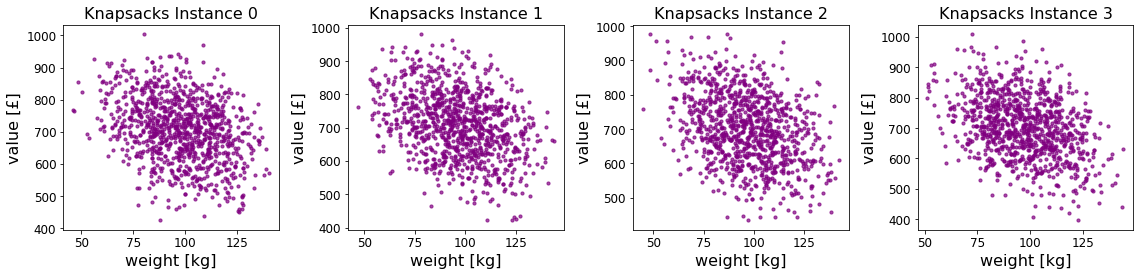

In [12]:
nplots = n_instances
ncols = 4
nrows = nplots // ncols + np.sum(nplots % ncols != 0)

plt.figure(figsize=(4 * ncols, 4 * nrows))

for idx_instance in knapsacks_instances:
    plt.subplot(nrows, ncols, idx_instance + 1)
    
    plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                [knapsacks['value'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                s=10, alpha=0.7, color='purple')

    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    plt.title(f'Knapsacks Instance {idx_instance}', fontsize=MEDIUM_SIZE)
plt.tight_layout()

In the above we see that even though the distributions in Objective Space (weight, value) trace similar trends, each has its own distinct features that will impact the Pareto Front.  

Can you identify by eye the Pareto Front for each instance?    
(Beforehand you will need define the Optimisation Objectives! E.g, minimising weight and maximising value.)

## Optimisation Objective

In the knapsack problem we want to optimise for two objectives:    
* ↓ minimise the knapsack weight 
* ↑ maximise the moentary values of the packages in the knapsack
 
 
**Note**    
The default setting here is ↓↑, but feel free to explore the other combinations: ↓↓, ↑↓ or ↑↑. (See the ***CHANGE ME!*** for `objective_mode`).    

In [13]:
from operator import lt as less_than, gt as greater_than
from operator import (truediv as div, mul)

In [14]:
# Objective Space declaration

# CHANGE ME!
objective_mode, heuristic, soh_unit = {'weight': 'min', 'value': 'max'}, 'value/weight', '£/kg'
#objective_mode, heuristic, soh_unit = {'weight': 'min', 'value': 'min'}, '1/value/weight', '1/£/kg'
#objective_mode, heuristic, soh_unit = {'weight': 'max', 'value': 'max'}, 'value*weight',  '£*kg'
#objective_mode, heuristic, soh_unit = {'weight': 'max', 'value': 'min'}, 'weight/value', 'kg/£'

In [15]:
# These objects are used to calculate the relationships between the knapsacks.

# for Single Objective Optimisation
direction_to_multiplier = {'min': div, 'max': mul}

# for Pareto Optimal selection
mode_to_operator = {'min': less_than, 'max': greater_than}
objective_operator = {key: mode_to_operator[objective_mode[key]] for key in objective_mode.keys()}

## Pareto Front Calculation

 

We will use the `knapsacks_to_pareto_front` function where:  
* input: dictionary of knapsacks
* output: list of indexes of knapsacks that are Pareto optimal

This is the same algorithm used in the previous notebook for which we detailed the pseudocode. 

In [16]:
def knapsacks_to_pareto_front(knapsacks):
    objective_values = {}

    for objective in objectives:
        objective_values[objective] = [knapsacks[idx][objective] for idx in knapsacks]
        
    idxs_pareto = []
    
    idx_objects = list(knapsacks.keys())

    for idx in range(len(objective_values[objective])):
        is_pareto = True

        this_weight = objective_values['weight'][idx]
        this_value = objective_values['value'][idx]

        other_weights = np.array(objective_values['weight'][:idx] + objective_values['weight'][idx + 1:])
        other_values = np.array(objective_values['value'][:idx] + objective_values['value'][idx + 1:])

        for jdx in range(len(other_weights)):
            other_dominates = objective_operator['weight'](other_weights[jdx], this_weight) & objective_operator['value'](other_values[jdx], this_value)   

            if other_dominates:
                is_pareto = False
                break

        if is_pareto:
            idxs_pareto.append(idx_objects[idx])
            
    return idxs_pareto

In [17]:
# calculating the pareto front for each instance

pareto_instances = {}
for idx_instance in knapsacks_instances:
    pareto_instances[idx_instance] = knapsacks_to_pareto_front(knapsacks_instances[idx_instance])

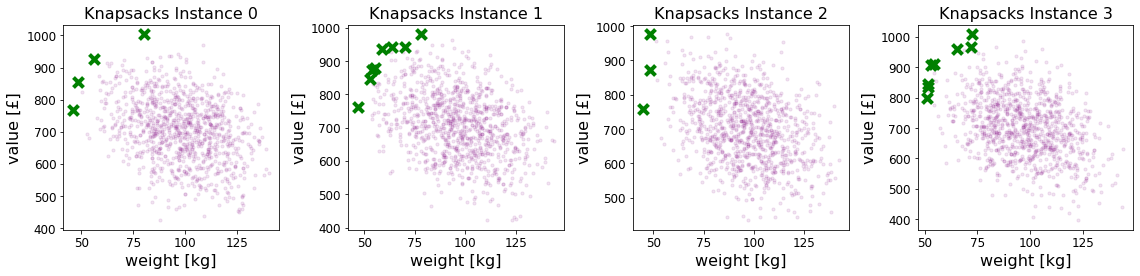

In [18]:
# visualising the knapsack set instances with an emphasis on the Pareto fronts

nplots = n_instances
ncols = 4
nrows = nplots // ncols + np.sum(nplots % ncols != 0)

plt.figure(figsize=(4 * ncols, 4 * nrows))

for idx_instance in knapsacks_instances:
    plt.subplot(nrows, ncols, idx_instance + 1)
    
    plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                [knapsacks['value'] for _, knapsacks in knapsacks_instances[idx_instance].items()],
                s=10, alpha=0.1, color='purple')
    
    plt.scatter([knapsacks_instances[idx_instance][idx_knapsack]['weight'] for idx_knapsack in pareto_instances[idx_instance]], 
                [knapsacks_instances[idx_instance][idx_knapsack]['value'] for idx_knapsack in pareto_instances[idx_instance]], 
            marker='x', s=100, linewidth=4, color='green', label='Pareto Front')

    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    plt.title(f'Knapsacks Instance {idx_instance}', fontsize=MEDIUM_SIZE)
plt.tight_layout()

Did you manage to correctly identify the Pareto front for each instance? 

We clearly see that each instance is a subset of the full space resulting in wildly different Pareto front approximations. 

Next we will see that we can combine the four instances to one to obtain a mutual Pareto front approximation which is better than each individual.

In [19]:
# knapsacks_pareto_combined is a set of indexes of that knapsacks that are pareto optimal of the combined set of all instances 

knapsacks_pareto = {}
instance_pareto_details = {}
for idx_instance in knapsacks_instances:
    for idx_knapsack in pareto_instances[idx_instance]:
        idx_pareto = f'{idx_instance}-{idx_knapsack}'
        knapsacks_pareto[idx_pareto] = knapsacks_instances[idx_instance][idx_knapsack]
        instance_pareto_details[idx_pareto] = idx_instance


knapsacks_pareto_combined = knapsacks_to_pareto_front(knapsacks_pareto)

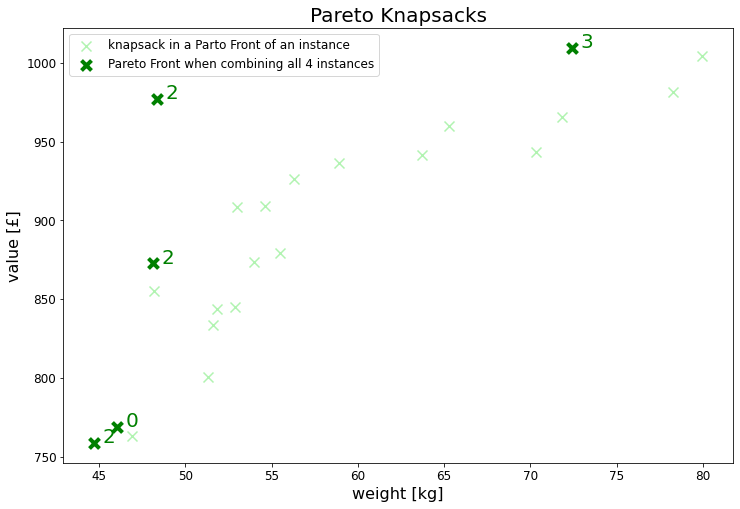

In [20]:
# visualising each instance pareto front (light Xs) and the combined pareto front (thick Xs)

plt.scatter([knapsacks['weight'] for _, knapsacks in knapsacks_pareto.items()],
            [knapsacks['value'] for _, knapsacks in knapsacks_pareto.items()],
            marker='x', s=100, alpha=0.7, color='lightgreen', label='knapsack in a Parto Front of an instance')

plt.scatter([knapsacks_pareto[idx_knapsack]['weight'] for idx_knapsack in knapsacks_pareto_combined], 
            [knapsacks_pareto[idx_knapsack]['value'] for idx_knapsack in knapsacks_pareto_combined], 
        marker='x', s=100, linewidth=4, color='green', label=f'Pareto Front when combining all {n_instances} instances')

for idx_knapsack in knapsacks_pareto_combined:
    plt.annotate(instance_pareto_details[idx_knapsack], [knapsacks_pareto[idx_knapsack]['weight'] + 0.5, knapsacks_pareto[idx_knapsack]['value']], fontsize=20, color='green')

plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title(f'Pareto Knapsacks')
plt.legend()

This visualisation clearly shows that combining multiple instances/subsets to one results in a Pareto front approximation that is better than those of each individual.


The take away from this is it that is recommended to combine solutions from different initial seeds.  This approach is called ***niching***. Niching is a manner in which you can explore more effectively the Decision Space without runing into local minima/maxima in the Objective Space. Local minima (when minimising) and maxima (when maximising) is when an algorithms is stuck at a result that is optimal locally, but not globally, e.g: 

<img src="https://upload.wikimedia.org/wikipedia/commons/6/68/Extrema_example_original.svg" width=300>

Another way of thinking about niching is that it is a mechanism to obtain a more diverse set of solutions which results in a better Pareto front approximation.


As an over-simplistic analogy consider our ancestors leaving the [Cradle of Humankind](https://en.wikipedia.org/wiki/Cradle_of_Humankind) about 50,000 years ago. In effect they seeded different populations in Europe, Far East and Australia while others remained in Africa. Each developed its own culture to make the world a richer place in terms of diversity, as opposed to everyone being the same. This analogy is imperfect in many ways, but hopefully gives a picture to have in mind. 

<img src="https://images.ctfassets.net/cnu0m8re1exe/3O1R69w3U6bLrBS6ig5J9E/a875a35bd1ae07693908b12ca2e5e73a/bae1HR-1024x532.jpg?w=650" width=500>


This analogy is our segue way to the next topic of having an initial population "learn" to create more fit ones ( "learning" doesn't mean that the algorithm will understand, but rather improve its results based on random actions). In the next section we will learn about Genetic Algorithms.   

# Genetic Algorithm Components


## Genetic Algorithm

**What?**   
Inspired by Darwin's theory of evolution, in 1960 John Holland introduced [Evolutionary Computation](https://en.wikipedia.org/wiki/Evolutionary_computation) as a family of algorithms for optimisation. The main idea is to have a population-based trial and error problem solvers with a stochastic optimisation character.  

[Genetic Algorithms](https://en.wikipedia.org/wiki/Genetic_algorithm) is one technique which is commonly used to generate high-quality solutions to optimisation and search problems. It relies on biologically inspired operators such as mutation, crossover and selection, which we will explore in detail.  

Perhaps it is best to have in mind a quote from the 17th century English writer and gardener John Evelyn:  

<img src="https://www.azquotes.com/picture-quotes/quote-explore-everything-keep-the-best-john-evelyn-121-91-15.jpg" width=500>


**Why?**  
We will use it for the knapsack problem because:  
* It works well for intractable combinatorial spaces  
* Diversity, Niching - it finds multiples solutoins and we start from different starting points. 
* It is simple to implement




There are many ways to construct a Genetic Algorithm, e.g, in the following illustration.

<img src="http://aqibsaeed.github.io/img/ga.png" width=500>  

(image credit: [Aaqib Saeed](http://aqibsaeed.github.io/2017-08-11-genetic-algorithm-for-optimizing-rnn/)).

We will now explore the various components of the Genetic Algorithm with an emphasis on the role of Pareto Optimisation in the selection function.  

Troughout we will refer to a knapsack as an ***individual*** wherase a set of them is a ***population***.  

##  Initial Population
`create_knapsacks` is the same function we used in [Niching](#Niching).  

In [21]:
N_INITIAL_POPULATION = 20
seed = 3141592653

population = create_knapsacks(N_INITIAL_POPULATION, seed=seed)

## Cross Over Algorithm

One of two transformation functions used in the Genetic Algorithm.  

The following image uses DNA snippets to illustrate the how the crossover tranformation may be generate two children solutions from two parents. 

![crossover](https://user-images.githubusercontent.com/6064016/97842646-dc0c2400-1cdf-11eb-8b59-f0c70274d606.png)

 

In this analogy:  
* A DNA strip corresponds to a knapsack
* The nucleotides (`A`, `C`, `G`, `T`) correspond to the packages (except for the fact that we are using unique packages).

Here we present a few functions 
* `cross_over_2_indvs` - generates two children by crossing over (mating) two parents 
* `crossover_knapsacks` - generates `len(knapsacks)` children for input `knapsacks`  

### Parents To Children

In [22]:
# Cross over of a pair of parents to a pair of children

def cross_over_2_indvs(ind1, ind2):
    # here we assume:
    # both individuals are non empty lists with the same length
    # a crossover cuts through the middle of the lists
    # Caveat! the [n_//2:] operation below means that we do not want the packages to be sorted because that is likely to cause drop in diversity.
    
    assert len(ind1) == len(ind2)
    
    mutuals = list(set(ind1) & set(ind2))
    
    non_overlap1 = [ind for ind in ind1 if ind not in mutuals]
    non_overlap2 = [ind for ind in ind2 if ind not in mutuals]
    
    ind1_ = non_overlap1.copy()
    ind2_ = non_overlap2.copy()
    
    n_ = len(ind1_)
    
    ind1_[n_//2:] = non_overlap2[n_//2:]
    ind2_[n_//2:] = non_overlap1[n_//2:]
    
    ind1_ += mutuals
    ind2_ += mutuals
    
    return ind1_, ind2_

In [23]:
# dummy example - for this example we are not using packages in knapsacks but rather characters in a list

parent1 =  ['A', 'B', 'C', 'D', 'E']
parent2 = [1, 2, 3, 4, 'C']

print(f'parent 1: {", ".join(parent1)}')
print(f'parent 2: {", ".join(map(str,parent2))}')

child1, child2 = cross_over_2_indvs(parent1, parent2)
print(f'\ncrossed over to\nchild 1: {", ".join(map(str, child1))}\nchild 2: {", ".join(map(str, child2))}')

parent 1: A, B, C, D, E
parent 2: 1, 2, 3, 4, C

crossed over to
child 1: A, B, 3, 4, C
child 2: 1, 2, D, E, C


**A deeper look**

In this dummy example the `C` character appears in both parents and is passed on to both children (rather than one child having two `C`s and the other none). This corresponds to the `mutuals` term in the `cross_over_2_indvs` function. 

In [24]:
# knapsack working example

idx_indv1 = 0  # change me! index of knapsack
idx_indv2 = 1  # change me! index of knapsack
# -------

parent1 = population[idx_indv1]['packages']
parent2 = population[idx_indv2]['packages']

print(f'parent 1: {", ".join(map(str,parent1))}')
print(f'parent 2: {", ".join(map(str,parent2))}')

child1, child2 = cross_over_2_indvs(parent1, parent2)
print(f'\ncrossed over to\nchild 1: {", ".join(map(str, child1))}\nchild 2: {", ".join(map(str, child2))}')

parent 1: 14, 12, 4, 1, 5, 9, 19, 7, 15, 13
parent 2: 0, 17, 12, 19, 1, 15, 7, 9, 11, 4

crossed over to
child 1: 14, 17, 11, 1, 4, 7, 9, 12, 15, 19
child 2: 0, 5, 13, 1, 4, 7, 9, 12, 15, 19


###  Population
`crossover_knapsacks` is a wrapper for `cross_over_2_indvs`.  
 

It separates the input knapsacks to pairs of parents and then runs each pair through `cross_over_2_indvs`. This results in `len(knapsacks)` children. 

In [25]:
def crossover_knapsacks(population, packages, idx_start=None):
    n_population = len(population)
    
    idxs_parents = list(population.keys())
    
    idxs_parent2 = idxs_parents[1::2]
    idxs_parent1 = idxs_parents[::2][:len(idxs_parent2)]
    
    children = {}
    
    if idx_start is None:
        idx_child_counter = np.max(idxs_parents) # TODO: this does not generalise well since indviduals will be dropped
    else:
        idx_child_counter = idx_start
        
    for idx_parent1, idx_parent2 in zip(idxs_parent1, idxs_parent2):
        idx_child_counter += 1
        children[idx_child_counter] = {}
        children[idx_child_counter + 1] = {}
        
        children[idx_child_counter]['packages'], children[idx_child_counter + 1]['packages'] = cross_over_2_indvs(population[idx_parent1]['packages'], population[idx_parent2]['packages'])
        
        idx_child_counter += 1
    
    return children
       
children = crossover_knapsacks(population, packages)

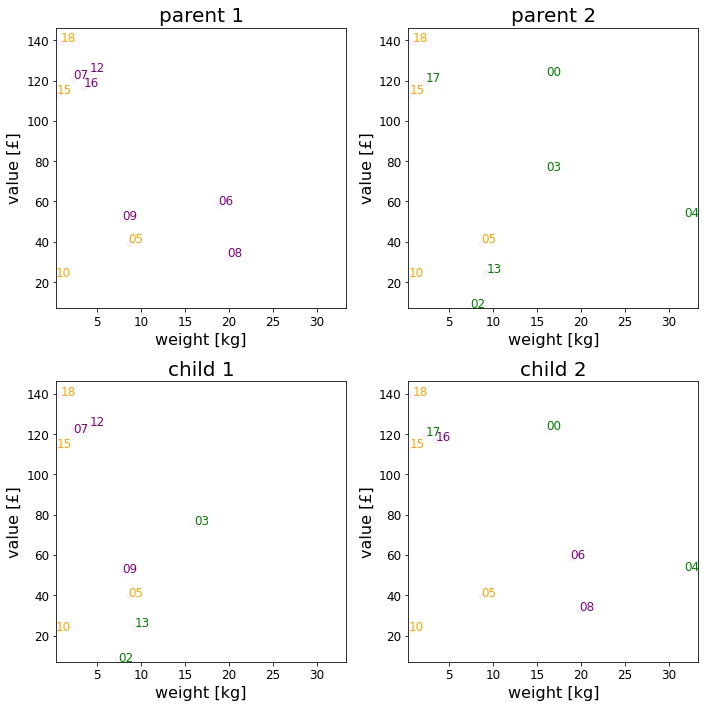

In [26]:
# Examining the Decision Space (packages) of one pair of parents their resulting cross over children.

idx_parent1 = 4
assert idx_parent1 % 2 == 0
knapsacks_plot = {'parent 1': population[idx_parent1], 'parent 2': population[idx_parent1 + 1],
                  'child 1': children[min(list(children.keys())) + idx_parent1],
                  'child 2': children[min(list(children.keys())) + idx_parent1 + 1]
                 }

colors = {'parent 1': 'purple', 'parent 2': 'green', 'both': 'orange'}

# parents_packages = list(set(list(population[0]['packages']) + list(population[1]['packages'])))
# min_weight = np.min([packages[package]['weight'] for package in parents_packages])
# max_weight = np.max([packages[package]['weight'] for package in parents_packages])
# min_value = np.min([packages[package]['value'] for package in parents_packages])
# max_value = np.max([packages[package]['value'] for package in parents_packages])

min_weight = np.min([packages[package]['weight'] for package in packages])
max_weight = np.max([packages[package]['weight'] for package in packages])
min_value = np.min([packages[package]['value'] for package in packages])
max_value = np.max([packages[package]['value'] for package in packages])

ncols = 2
nrows = 2

plt.figure(figsize = (5 * ncols, 5 * nrows))

for ipanel, knapsack_idx in enumerate(knapsacks_plot):
    plt.subplot(nrows, ncols, ipanel + 1)
    
    idx_packages_in_knapsack = knapsacks_plot[knapsack_idx]['packages']
    
    plt.scatter([packages[idx_package]['weight'] for idx_package in idx_packages_in_knapsack],
                [packages[idx_package]['value'] for idx_package in idx_packages_in_knapsack],
                color = 'purple', alpha=0.04
               )
    
    #counts_ = {'both': 0, 'parent 1': 0, 'parent 2': 0}
    for idx_package in idx_packages_in_knapsack: 
        in_parent1 = idx_package in knapsacks_plot['parent 1']['packages']
        in_parent2 = idx_package in knapsacks_plot['parent 2']['packages']
        
        if in_parent1 & in_parent2:
            color = colors['both']
            #counts_['both'] += 1
        elif in_parent1:
            color = colors['parent 1']
            #counts_['parent 1'] += 1
        elif in_parent2:
            color = colors['parent 2']
            #counts_['parent 2'] += 1
        else:
            print('problem!')
            break
        
        plt.annotate(f'{idx_package:02.0f}', xy=(packages[idx_package]['weight'], packages[idx_package]['value']), alpha=1, color=color)
        
    #print(knapsack_idx, counts_)
    
    plt.title(knapsack_idx)
    
    plt.xlim(min_weight * 0.95, max_weight * 1.05)
    plt.ylim(min_value * 0.95, max_value * 1.05)
    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')
    
plt.tight_layout()

The color coding is as follows: 
* Purple packages are those that originate from only parent 1
* Green packages are those that originate from only parent 2
* Orange packages are those that originate from both parent 1 and 2

We see that both children's packages are crossed over from both parents.

## Mutation

The following uses DNA snippets to illustrate how the mutation tranformation may be applied to one parent solutions to generate one child.

![mutation](https://user-images.githubusercontent.com/6064016/97843727-b54eed00-1ce1-11eb-943f-c725b7fc49ed.png)


We will use the function `mutate_knapsack` that takes in an individual knapsack and replaces `n_mutate` packages to created a mutated child knapsack.

In [27]:
def mutate_knapsack(indv_package_idxs, all_package_idxs, n_mutate=1, seed=None):
    remaining_package_idxs = list(set(all_package_idxs) - set(indv_package_idxs))
    
    np.random.seed(seed)
    loc_mutate = np.random.choice(range(len(indv_package_idxs)), n_mutate, replace=False)
    new_package_idxs = np.random.choice(remaining_package_idxs, n_mutate, replace=False)
    
    indv_package_idxs_ = indv_package_idxs.copy()

    for i, loc in enumerate(loc_mutate):
        indv_package_idxs_[loc] = new_package_idxs[i]
    
    return indv_package_idxs_

In [28]:
all_packages = list(packages.keys())
n_packages_mutate = 2    # CHANGE ME!
seed = 2

idx_indv = 0
individual = population[idx_indv]['packages']

print(f'individual original: {", ".join(map(str,individual))}')
individual_mutated = mutate_knapsack(individual, all_packages, n_mutate=n_packages_mutate, seed=seed)
print(f'individual mutated : {", ".join(map(str,individual_mutated))}')
print(f'{len(set(individual) & set(individual_mutated))} packages remain and {len(set(individual) - set(individual_mutated))} were changed')

individual original: 14, 12, 4, 1, 5, 9, 19, 7, 15, 13
individual mutated : 14, 11, 4, 1, 2, 9, 19, 7, 15, 13
8 packages remain and 2 were changed


## Fitness Evaluation

Fitness means the values of the objectives (weight, value). Here we use `knapsack_objective`, the same algorithm as in the previous notebook.

Here we will apply the algorithm to three of the children generated above (two from crossover, one from mutation) and examine how competitive they are against the original population.

In [29]:
# defining the new generation

population_born = {'child 1': {'packages':child1}, 'child 2': {'packages':child2}, 
                   'individual_mutated': {'packages': individual_mutated}
                  }
population_born

{'child 1': {'packages': [14, 17, 11, 1, 4, 7, 9, 12, 15, 19]},
 'child 2': {'packages': [0, 5, 13, 1, 4, 7, 9, 12, 15, 19]},
 'individual_mutated': {'packages': array([14, 11,  4,  1,  2,  9, 19,  7, 15, 13])}}

In [30]:
# evaluating the fitness of the new generation

for _, indv in population_born.items():
    for objective in objectives:
        knapsack_objective(indv, objective, packages)
population_born    

{'child 1': {'packages': [14, 17, 11, 1, 4, 7, 9, 12, 15, 19],
  'weight': 92.8669222089192,
  'value': 770.2954735883773},
 'child 2': {'packages': [0, 5, 13, 1, 4, 7, 9, 12, 15, 19],
  'weight': 101.83251049309172,
  'value': 773.4176186474931},
 'individual_mutated': {'packages': array([14, 11,  4,  1,  2,  9, 19,  7, 15, 13]),
  'weight': 103.12995451169887,
  'value': 558.442956775247}}

Text(0, 0.5, 'value [£]')

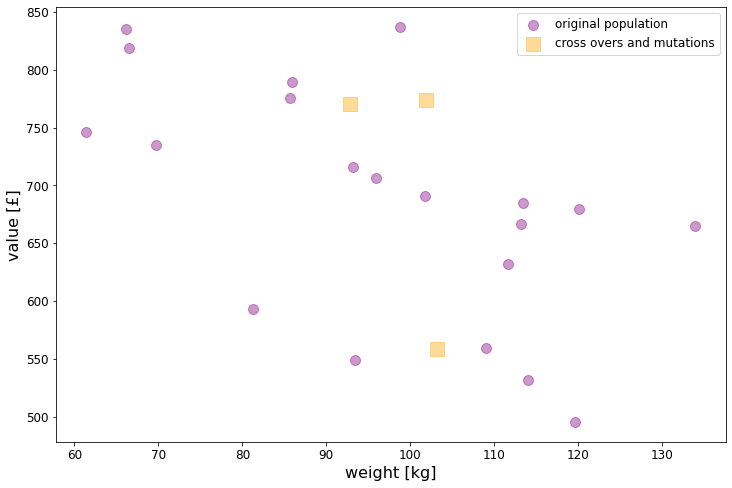

In [31]:
# visualising the population and the new population

plt.scatter([knapsacks['weight'] for _, knapsacks in population.items()],
                [knapsacks['value'] for _, knapsacks in population.items()],
                s=100, alpha=0.4, color='purple', label='original population')

plt.scatter([knapsacks['weight'] for _, knapsacks in population_born.items()],
                [knapsacks['value'] for _, knapsacks in population_born.items()],
                marker='s',s=200, alpha=0.4, color='orange', label='cross overs and mutations')
 

plt.legend()
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')

The visual above shows the distribution of the parent population (circles) and some selected children (squares).   

Results might differ by configuration, but generally speaking:  
There is not reason to be surprised if the children solutions/knapsacks are not Pareto optimal. That is the stochastic nature of this technique! At times we will get children that beat their parents, but not always (as an exterme case - we shouldn't always expect the children of Albert Einstein or Michael Jordan to perform better than their parents).

<img src="https://i.ytimg.com/vi/-YZNnUDrpbE/maxresdefault.jpg" width=500>



## Selection

This is where the Pareto front technique gets used!  

Imagine that we have a population competing to continue to the next generation. We need to choose a subset of the "most fit".   

We could just take the Pareto optimal solutions.   
That might not be adequate in exterme cases where we have a small set (e.g, of one), because this will result in a lack of diversity.  

For this reason we need to choose in advance the number individuals to progress to the next iteration. We'll call this `n_selection`.  

 
There are various algorithms that use the concept of Pareto optimality to choose the most diverse `n_selection` solutions.  

Here I describe a fairly simplistic one and will provide material on more advanced techniques.  

Let's look at is pseudocode, first.  

**Pseudocode**

* input
    * `population` - list or dictionary of solutions from which we want to select from
    * `n_selection` - determines the number of individuals to select for the next generation
    * `exact_n_selection` - boolean determining if we need exactly `n_selection` or to choose the all solutions from the final pareto front
* output
    * `pareto_fronts` - a list where each item is a list of indexes of the individuals that comprise of the pareto front. 

 
```python
 
population_remaining = population.copy()
individuals_selected = []
pareto_fronts = []
while len(individuals_selected) < n_selection:
    these_selected = find_pareto_optimal(population_remaining)
    
    # --- fro exact_n_selection=True we update these_selected ---
    if exact_n_selection:
         n_iterim_selected = len(these_selected) + len(individuals_selected)
        if n_iterim_selected > n_selection:
            n_subset = n_selection - len(individuals_selected)
            these_selected = choose_random(these_selected, n_subset)
    # ------
             
    pareto_fronts.append(these_selected)
    
    individuals_selected.append(these_selected)  # updating the selected
    population_remaining -= these_selected # updating the remaining population
    
```

Example:  
E.g, for `n_selection=7` could return `pareto_fronts=[[17, 49, 83], [5, 58, 25, 49]]`. This means that individuals  `[17, 49, 83]` comprise of the first Pareto front, but because it has less than 7 items, we also select an additional 4 from the next Pareto front (after excluding the first) resulting in `[5, 58, 25, 49]`. 


For the purpose of this demo we'll call this algorithm a Naive Pareto Selector.  

In [32]:
# naive pareto selector applied on the knapsacks

N_SELECTION = 10           # CHANGE ME!  the number of individuals to be selected (examine in visual below)
exact_n_selection = False  # CHANGE ME!  determines the number of individuals selected for the final pareto front (visual below)

idxs_knapsacks_selected = []

population_remaining = population.copy()

individuals_selected = []
pareto_fronts = []
while len(individuals_selected) < N_SELECTION:
    these_selected = knapsacks_to_pareto_front(population_remaining)
    
    n_these_selected_and_selected = len(these_selected) + len(individuals_selected)
    if exact_n_selection:
        if n_these_selected_and_selected > N_SELECTION:
            n_these_subset = N_SELECTION - len(individuals_selected)
            these_selected = np.random.choice(these_selected, n_these_subset, replace=False).tolist()

    pareto_fronts.append(these_selected)
    
    individuals_selected = [individual for pareto_front in pareto_fronts for individual in pareto_front]
    
    for individual in these_selected:
        del population_remaining[individual]
        
pareto_fronts    

[[1, 15, 19], [4], [6, 13, 14], [5, 18], [0, 2]]

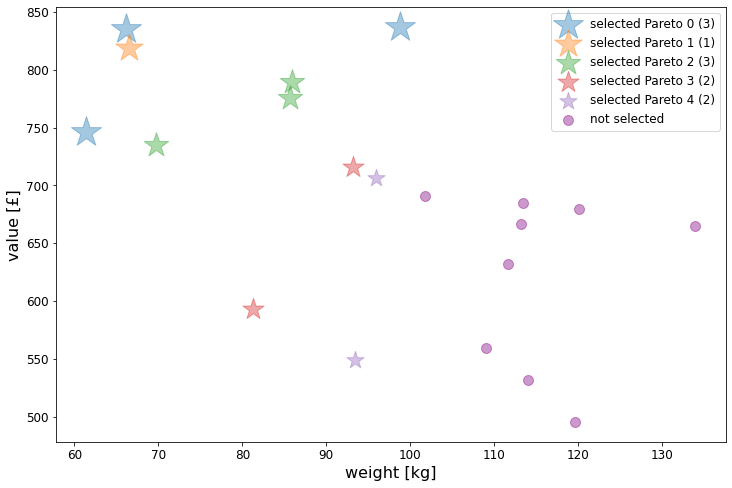

In [33]:
# visualising the outcome of the naive pareto selector

max_size = 1000
for ipareto, pareto_front in enumerate(pareto_fronts):
    size = max_size * (1. - ipareto/6)
    plt.scatter([population[idx_indv]['weight'] for idx_indv in  pareto_front],
                [population[idx_indv]['value'] for idx_indv in  pareto_front],
                marker='*',s=size, alpha=0.4, label=f'selected Pareto {ipareto} ({len(pareto_front)})',)

plt.scatter([knapsacks['weight'] for _, knapsacks in population.items() if _ not in individuals_selected],
                [knapsacks['value'] for _, knapsacks in population.items() if _ not in individuals_selected],
                 s=100, alpha=0.4, color='purple', label='not selected')
    
plt.legend()
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
pass

In this visual we can see the how the Naive Pareto Selector works.  
Given the optimisation objectives it first selects all the Pareto optimal solutions, marked as blue large stars.  
If this number is less than `n_selection` it goes for the next Pareto front marked as slighly smaller orange stars. This continues until `n_selection` is reached.   

For those interested in more advance selection function algorithms, we suggest looking into state of the art algorithms: 
* `SPEA2` - Strength Pareto Evolutionary Algorithm 
* `NSGA-II` -  Non-dominated Sorting Genetic Algorithm
* `IBEA` - Indicator-Based Evolutionary Algorithm  

They account for further details that are beyond the scope of this notebook:  
* Elitism - a fraction of the selected individuals progress to the next generation, bypassing the mutation and crossover processes
* Density estimation - optimised to reduce the density of selected solution in the Objective Space 
* Preserving edge results - preserves edge solutions in the Objective space
* Pareto Front heuristics for comparisons



This concludes the components of the Genetic Algorithm.  
Let's put them together to see learning in action!  

# Knapsack Optimisation

Now we'll put all the components together and examine the evolution of the Pareto front estimates of the Knapsack problem!

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fd/Knapsack.svg" width=250>

The next two cells comprise of scripts that generate the initial population and apply selection.  

We will compare results of two different selectors: 
* `naive_pareto_selector` - as practiced in [Selection](#Selection) . Remember that this uses the advantages of Pareto optimisation: gives a broader scope for exploring the landscape.  
* `single_objective_selector` - Single Objective Optimisation discusses in the previous notebook. This is the more common approach of combining multiple paremters into one single heuristic. 

Whereas the Single Objective Optimisation is likely to be faster and demand less cognitive effort from the user, it is more likely to result in suboptimal solutions copared to the Pareto optimal selector. 

Still skeptic? You should be.  
Let's find out by applying to the knapsack problem!

Just beforehand, some more maintenance.  

We need to determine the probablity of each parent to transform to children. Some will crossover, some will mutate:  
* `PROB_CROSS_OVER` - probability of parent to create a child by crossover
* `PROB_MUTATION` - probability of parent to create a child by mutation  

* `PARENTS_COMPETE` is a boolean that determiness if parents compete with the children for the next generation. This is where the analogy to humans breaks down ... unless you are a fan of [The Highlander](https://en.wikipedia.org/wiki/Highlander_(film)). Geek paraphrasing:  

> "There can be ~only~ [$\ge$] one!").  


<img src="https://i.ytimg.com/vi/Oc9fUbjJbAU/maxresdefault.jpg" width=700>


If  `PARENTS_COMPETE=False` the parents do not compete, but they can still create a children as an exact replicates with probability   
`replicate_prob= 1 - PROB_CROSS_OVER - PROB_MUTATION`  

Friendly reminder:  In the first stage there is no need to understand all the lines of Python below. It's enough to have a general idea what each function does.

In [34]:
# -- selection --
PARENTS_COMPETE = True   # CHANGE ME! True: parents compete with children to be selected for the next generation. False: only children compete

# -- mating --
PROB_CROSS_OVER = 0.6    # CHANGE ME! probability that any parent may craete a child by mating with another parent

# -- mutation --
PROB_MUTATION = 0.4      # CHANGE ME! probability that any parent may create a child by mutating itself
N_PACKAGES_MUTATE = 2    # CHANGE ME! number of packages used for the process of mutation

In [35]:
# selection function algorithms

# same algorithm as above
def naive_pareto_selector(population, n_select=20, exact_n_selection = False):
    population_remaining = population.copy()
    
    individuals_selected = []
    pareto_fronts = []
    
    while len(individuals_selected) < n_select:
        these_selected = knapsacks_to_pareto_front(population_remaining)

        n_these_selected_and_selected = len(these_selected) + len(individuals_selected)
        if exact_n_selection:
            if n_these_selected_and_selected > n_select:
                n_these_subset = n_select - len(individuals_selected)
                these_selected = np.random.choice(these_selected, n_these_subset, replace=False).tolist()

        pareto_fronts.append(these_selected)

        individuals_selected = [individual for pareto_front in pareto_fronts for individual in pareto_front]

        for individual in these_selected:
            del population_remaining[individual]
            
    return pareto_fronts,  individuals_selected


# calculating the single objective heuristic for each knapsack (soh) 
# same function as in the previous notebook
def knapsack_to_soh(knapsack):
    # generalising 
    # (weight,value) : returns single-objective-heuristic
    # (↓, ↑) : returns knapsack['value'] / knapsack['weight'] 
    # (↑, ↑) : returns knapsack['value'] * knapsack['weight'] 
    # etc.
    
    value_heuristic    = direction_to_multiplier[objective_mode['value']](1, knapsack['value'])
    weight_heuristic   = direction_to_multiplier[objective_mode['weight']](1, knapsack['weight'])
    return  value_heuristic * weight_heuristic

# selection function for Single Objective Optimisation: chooses the top `n_select` individuals
def single_objective_selector(population, n_select=20, objective='value_weight_ratio'):    
    population_sorted = {k: v for k, v in sorted(population.items(), key=lambda indv: indv[1][objective], reverse=True)} 
    
    return {k: population_sorted[k] for k in list(population_sorted.keys())[:n_select]} 

In [36]:
# algorithms for creation of children

# creates the children
def create_children(idx_indv_start, idxs_parents, population_parents, n_packages_mutate=None):
    idxs_chidren = {}
    
    if n_packages_mutate is None:
        n_packages_mutate = N_PACKAGES_MUTATE
    
    # children replicated
    idxs_chidren['replicated'] = list(np.arange(idx_indv_start, idx_indv_start + len(idxs_parents['replicate'])))
    population_children = {idxs_chidren['replicated'][counter]: population_parents[idx_indv] for counter, idx_indv in enumerate(idxs_parents['replicate'])}

    if idxs_chidren['replicated']:
        idx_indv_max = np.max(idxs_chidren['replicated'])
    else:
        idx_indv_max = idx_indv_start
        
    # children mutated
    idxs_chidren['mutated'] = np.arange(idx_indv_max + 1, idx_indv_max + 1 + len(idxs_parents['mutate']))

    for (idx_parent, idx_child) in zip(idxs_parents['mutate'], idxs_chidren['mutated']):
        population_children[idx_child] = {}

        seed_ = seed + idx_child

        parent = population_parents[idx_parent]['packages']
        population_children[idx_child]['packages'] = mutate_knapsack(parent, all_packages, n_mutate=n_packages_mutate, seed=seed_)

    idx_indv_max = np.max(idxs_chidren['mutated']) 
    
    # children cross-overs
    population_parents_mate = {idx_parent: population_parents[idx_parent] for idx_parent in population_parents if idx_parent in idxs_parents['mate']}
    population_children_crossovers = crossover_knapsacks(population_parents_mate, packages, idx_start=idx_indv_max)

    idxs_chidren['crossed_over'] = [] # not sure if required. delete?
    for idx_child in population_children_crossovers:
        assert not idx_child in population_children
        population_children[idx_child] = {}
        population_children[idx_child] = population_children_crossovers[idx_child]
        
        idxs_chidren['crossed_over'].append(idx_child)
        
    return population_children, idxs_chidren
    

# determines the parents indices for replication, mutation, mating
def population_tranformations_idxs(idxs_parents, cx_prob, mutate_prob, parents_compete=True, seed=None):
    np.random.seed(seed)
    
    if parents_compete:
        # no need for replicates
        replicate_prob = 0
        mutate_prob = 1. - cx_prob  # we are concerned with only mutating a mating
    else:
        replicate_prob = 1. - cx_prob - mutate_prob
    
    transformation_idxs_parents = {}
    
    transformation_idxs_parents['replicate'] = set(np.random.choice(list(idxs_parents),  int(len(idxs_parents) * replicate_prob), replace=False))
    transformation_idxs_parents['mutate'] = set(np.random.choice(list(idxs_parents),  int(len(idxs_parents) * PROB_MUTATION), replace=False))
    #print(type(idxs_parents), type(transformation_idxs_parents['replicate']), type(transformation_idxs_parents['mutate']))
    transformation_idxs_parents['mate'] = idxs_parents - transformation_idxs_parents['replicate'] - transformation_idxs_parents['mutate']

    # randomising (keeping list in order to keep random order. perhaps best done in the cross-over function ...)
    transformation_idxs_parents['mate'] = list(np.random.choice(list(transformation_idxs_parents['mate']), len(transformation_idxs_parents['mate']), replace=False))
    
    return transformation_idxs_parents

In [37]:
# the main part of the algorithm

# logging the individuals
def _update_log(gen_num, this_gen, all_gens):
    for idx_indv in this_gen:
        if 'generations' not in all_gens[idx_indv]:
            all_gens[idx_indv]['generations'] = [] 
        all_gens[idx_indv]['generations'].append(gen_num)
        

# visualising pareto fronts
def plot_pareto_front(population, objective_to_sort='weight', label=None, marker='-o', color=None, linewidth=None, alpha=0.7, markersize=None):

    pareto_front_idxs = knapsacks_to_pareto_front(population)


    population_to_sort = {idx_indv: population[idx_indv] for idx_indv in population if idx_indv in pareto_front_idxs}
    population_sorted = {k: v for k, v in sorted(population_to_sort.items(), key=lambda indv: indv[1][objective_to_sort], reverse=False)}
    plt.plot([indv['weight'] for _, indv in population_sorted.items()],
             [indv['value'] for _, indv in population_sorted.items()], marker,
                     alpha=alpha, color=color, label=label, linewidth=linewidth, markersize=markersize)
    

# the genetic algorithm
def knapsack_genetic_algorithm(n_generations, n_initial_population=None, unique_indvs=False, n_packages_mutate=None,  
                               cx_prob=None, mutate_prob=None, seed=None, n_select=None, exact_n_selection=False, 
                               parents_compete=None, selector='pareto_naive', visualise=True, display_pareto_front=True):
    if not cx_prob:
        cx_prob = PROB_CROSS_OVER
    if not mutate_prob:
        mutate_prob = PROB_MUTATION
    if not n_packages_mutate:
        n_packages_mutate = N_PACKAGES_MUTATE
    if not n_initial_population: 
        n_initial_population = N_INITIAL_POPULATION
    if parents_compete is None:
        parents_compete = PARENTS_COMPETE
    if n_select is None:
        n_select = n_initial_population
        
    # initial population
    population_parents = create_knapsacks(n_initial_population, seed=seed)
    
    if unique_indvs:
        population_parents = {frozenset(population_parents[key]['packages']): population_parents[key] for key in population_parents}
    
    # evaluating fitness of the initial population
    if 'single_objective_optimisation' == selector:
        for idx_indv, indv in population_parents.items():
            indv['value_weight_ratio'] = knapsack_to_soh(indv)
    
    # creating log of all individuals
    population_all_generations = {idx_indv: {'packages': population_parents[idx_indv]['packages']} for idx_indv in population_parents}
    
    for gen_num in range(n_generations):
        # keeping track of highest valued individual (useful when unique_indvs=False)
        idx_indv_max = len(population_all_generations) - 1
        
        # --- population tranformations ---
        # dictionary containing the the transofrmations (replicate, mutate, mate) and the idxs of parents that will go through each transformation
        idxs_parents_tranformations = population_tranformations_idxs(set(population_parents.keys()), cx_prob, mutate_prob, parents_compete=parents_compete, seed=seed)
        
        # generating the children popultation basedon the tranformation of the parents 
        population_children, idxs_chidren = create_children(idx_indv_max, idxs_parents_tranformations, population_parents, n_packages_mutate=n_packages_mutate)
        if unique_indvs:
            population_children = {frozenset(population_children[key]['packages']): population_children[key] for key in population_children}
        
        for idx_indv, indv in population_children.items():
            if idx_indv not in population_all_generations:
                population_all_generations[idx_indv] = {} 
                population_all_generations[idx_indv]['packages'] = population_children[idx_indv]['packages']
        
        # --- evaluating the children fitness ---
        for idx_indv, indv in population_children.items():
            for objective in objectives:
                if objective not in indv:
                    knapsack_objective(indv, objective, packages)
                    
            if 'single_objective_optimisation' == selector:
                indv['value_weight_ratio'] = knapsack_to_soh(indv)
        
                    
        # --- selection ---
        # population for selection (children only or parents+children)
        if parents_compete:
            # pooling parents and children together to compete for selection
            population_competing = {**population_parents, **population_children} # was called population_parents_and_children
            _update_log(gen_num, population_competing, population_all_generations)
        else:
            # only children compete for selection
            population_competing = population_children.copy()
            _update_log(gen_num, {**population_parents, **population_children}, population_all_generations)

        # the selection function: Naive Pareto Selector or Single Objective Optimisation 
        if 'single_objective_optimisation' == selector:
            individuals_selected = single_objective_selector(population_competing, n_select=n_select)
            pareto_fronts = None
        else:
            pareto_fronts, individuals_selected = naive_pareto_selector(population_competing, 
                              n_select=len(population_parents), exact_n_selection=exact_n_selection)

        
        # --- plotting ---
        if visualise:
            alpha = 0.4

            pf_marker = '-'
            color = 'gray'
            linewidth = 2
            if gen_num in [0, n_generations - 1]: 
                if 0 == gen_num:
                    marker = 's'
                    size = 40
                    color = 'purple'
                    linewidth = 5
                else:
                    marker = 'x'
                    size = 100
                    color = 'green'
                    linewidth = 5

                label = f'competitors gen {gen_num + 1}'
                plt.scatter([knapsacks['weight'] for _, knapsacks in population_competing.items()],
                                [knapsacks['value'] for _, knapsacks in population_competing.items()],
                                 s=size, alpha=0.7, color=color, label=label, marker=marker, linewidth=4)
                label= f'pareto front gen {gen_num + 1}'
            else:
                label = None
                
            if display_pareto_front:
                plot_pareto_front(population_competing, objective_to_sort='weight', label=label, marker=pf_marker, color=color, linewidth=linewidth, alpha=alpha)
                

        
        
        # --- next generation ---
        population_parents = {idx_indv: population_competing[idx_indv] for idx_indv in population_competing.keys() if idx_indv in individuals_selected}
        
    plt.legend()
    plt.xlabel('weight [kg]')
    plt.ylabel('value [£]')   
    
    return population_all_generations

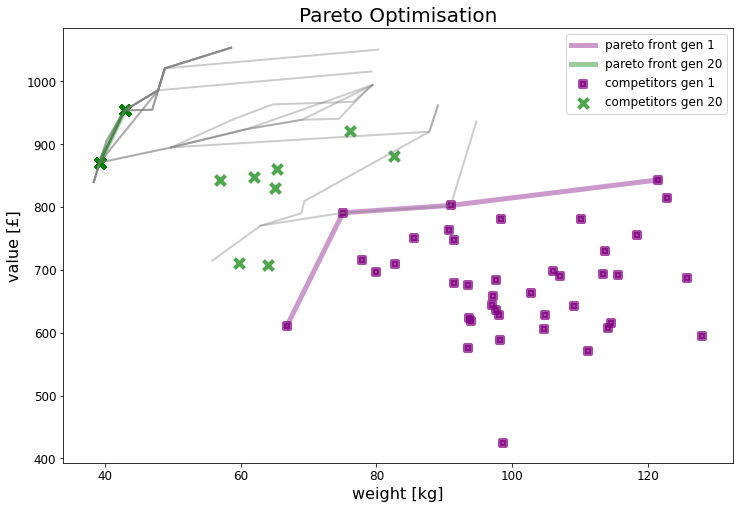

In [38]:
# running the knapsack problem with a genetic algorithm

n_generations = 20           # CHANGE ME! Number of iterations
n_initial_population = 20    # CHANGE ME!
parents_compete = True       # CHANGE ME! True: parents and children compete for selection, False: only children compete
unique_indvs = False         # CHANGE ME! True: no knapsack duplication, False: may have knapsack duplication
n_select = 20                # CHANGE ME! number of competing individuals selected for the next generation
exact_n_selection = True    # CHANGE ME! True: selector limited to n_select, False: selector might go above n_select (relevant for selector='pareto_naive')

display_pareto_front = True  # Visualises the Pareto front 
seed = 1                     # CHANGE ME! For different distributions and runs

selector = 'pareto_naive'    # Leave this selection function method. Below we compare with 'single_objective_optimisation'
population_all_pareto = knapsack_genetic_algorithm(n_generations, seed=seed, selector=selector, 
                                                   unique_indvs=unique_indvs, 
                                                   n_initial_population=n_initial_population,
                                                   n_select=n_select, exact_n_selection=exact_n_selection,
                                                   parents_compete=parents_compete,
                                                   display_pareto_front=display_pareto_front
                                                  )

plt.title('Pareto Optimisation')
ax = plt.gca()
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()

The above visual shows:  
* purple squares - all competing individuals in the first generation
* purple solid line - Pareto front of the first generation  

If  `n_generations>1` you will also see  
* greeen Xs - all competing individuals in the last generation
* green solid line - Pareto front of the last generation  
* gray thin lines (for `n_generations>2`) - Pareto fronts of all intermediate generations  

Tracking the Pareto front lines you should get a clear picture of how the genetic algorithm found better solutions.  

By increasing `n_generations` you will see improvement, until a certain point in which there is no reall cost benefit.  This does not mean that we have found the true Pareto front of this problem. More likely it got stuck in one (or more) local minima/maxima. 

Solving for this is out of the scope of this demo and requires further exploration. We discus this in [Summary](#Summary).

In the meanwhile let's compare results with the same algorithm that uses a different selection function: Single Objective Optimisation.  

How do you think that they will compare?

Text(0.5, 1.0, 'Single Objective Optimisation: value/weight')

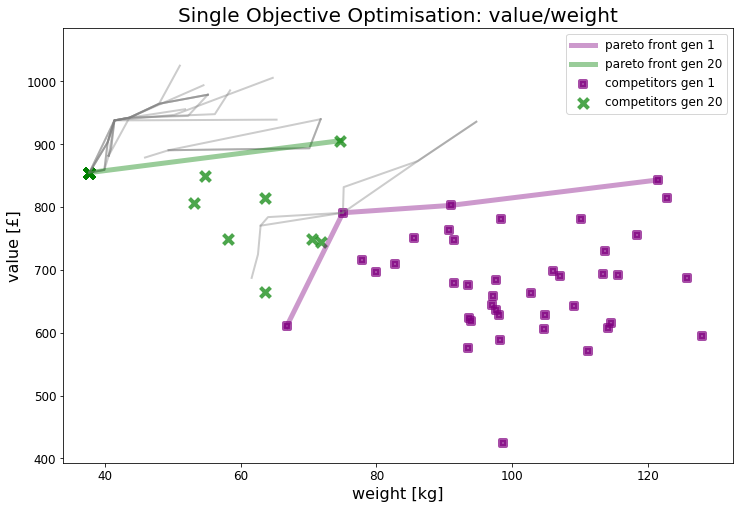

In [39]:
selector = 'single_objective_optimisation'
population_all_soh = knapsack_genetic_algorithm(n_generations, seed=seed, selector=selector, 
                                                   unique_indvs=unique_indvs, 
                                                   n_initial_population=n_initial_population,
                                                   n_select=n_select, exact_n_selection=exact_n_selection,
                                                   parents_compete=parents_compete,
                                                   display_pareto_front=display_pareto_front
                                                  )

plt.xlim(*x_lim)
plt.ylim(*y_lim)
plt.title(f'Single Objective Optimisation: {heuristic}')

This visual is the same as before but now using the Single Objective Optimisation approach for the selection function. 

Examine the plot to see if you can pick up on any difference.  
In the next few cells we will do direct comparisons between them.

In [40]:
# Evaluating objective values for populations (weight, value) as well as single objective heuristic: value/weight 

for idx_indv, indv in population_all_pareto.items():
    for objective in objectives:
        if objective not in indv:
            knapsack_objective(indv, objective, packages)
                    
    indv['value_weight_ratio'] = knapsack_to_soh(indv)
    
for idx_indv, indv in population_all_soh.items():
    for objective in objectives:
        if objective not in indv:
            knapsack_objective(indv, objective, packages)
                    
    indv['value_weight_ratio'] = knapsack_to_soh(indv)

The pareto run generated 420 individuals and the SOH generated 420


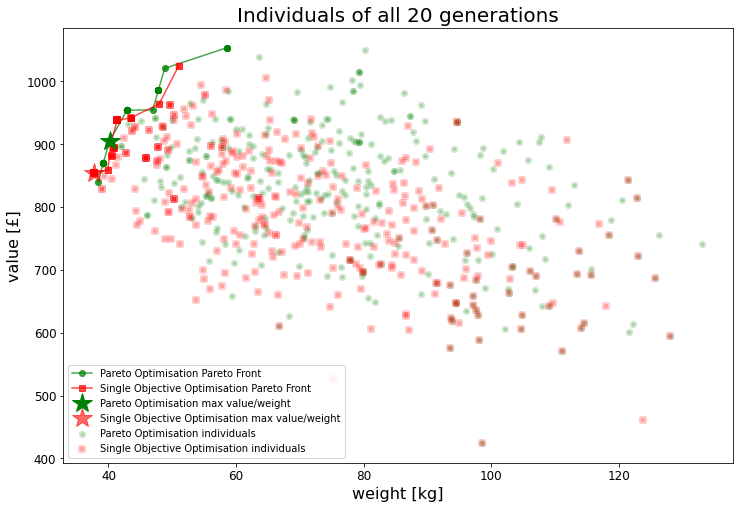

In [41]:
# visualising all individuals of both methods during for all generations


def jitter(x, loc=1., scale=0.005):
    return x * np.random.normal(loc, scale)

alpha = 0.2
size = 10
jitter_factor = 0.0  # CHANGE ME! e.g, 0.001. Set to a small factor to jitter the results. This is useful when wanting to visualise duplicates


print(f'The pareto run generated {len(population_all_pareto):,} individuals and the SOH generated {len(population_all_soh):,}')

indvs_pareto_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_pareto.items()])
indvs_pareto_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_pareto.items()])
plt.scatter(jitter(indvs_pareto_weights, scale = jitter_factor), jitter(indvs_pareto_values, scale = jitter_factor), 
            s=size, alpha=alpha, color='green', label='Pareto Optimisation individuals', marker=None, linewidth=4)


indvs_soh_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_soh.items()])
indvs_soh_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_soh.items()])
plt.scatter(jitter(indvs_soh_weights, scale = jitter_factor), jitter(indvs_soh_values, scale = jitter_factor),
            s=size, alpha=alpha, color='red', label='Single Objective Optimisation individuals', marker='s', linewidth=4)


plot_pareto_front(population_all_pareto, color='green', label='Pareto Optimisation Pareto Front')
plot_pareto_front(population_all_soh, color='red', label='Single Objective Optimisation Pareto Front', marker='-s')

indv_ = single_objective_selector(population_all_pareto, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='green', alpha=1, label=f'Pareto Optimisation max {heuristic}')

indv_ = single_objective_selector(population_all_soh, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='red', alpha=0.6, label=f'Single Objective Optimisation max {heuristic}')


plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title(f'Individuals of all {n_generations} generations')

plt.legend(fontsize=10)
# plt.xlim(*x_lim)
# plt.ylim(*y_lim)
pass

Note above that in addition to the Pareto fronts of both runs, we also highlight with a star the optimal single objective heuristic of each run.

**Diversity**     
Now we address the issue of diversity in the Decision Space.  

In the next two cells we will count knapsack duplicates. 
Note that the `sorted` function ensures that knapsacks like `[1,3,2]` are aggregated with `[1,2,3]` and the other permutations (`[2,3,1]` ...).  

In [42]:
# examining by eye the top knapsack duplications for all generations (Single Objective Optimisation)

import pandas as pd

top = 4

print(f'Duplication of Individuals in Single Objective (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in population_all_soh.items()]).value_counts().head(top)

Duplication of Individuals in Single Objective (showing top 4)


(2, 5, 7, 9, 10, 12, 15, 16, 17, 18)     38
(5, 7, 9, 10, 12, 15, 16, 17, 18, 19)    26
(2, 5, 7, 10, 12, 15, 16, 17, 18, 19)    12
(1, 5, 7, 9, 10, 12, 15, 16, 17, 18)      8
dtype: int64

In [43]:
# examining by eye the top knapsack duplications for all generations (Naive Pareto Selector)


print(f'Duplication of Individuals in Pareto Optimisation (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in population_all_pareto.items()]).value_counts().head(top)

Duplication of Individuals in Pareto Optimisation (showing top 4)


(7, 9, 10, 12, 14, 15, 16, 17, 18, 19)    43
(2, 7, 9, 10, 12, 14, 15, 16, 17, 18)     39
(0, 7, 9, 10, 12, 14, 15, 16, 17, 18)     18
(0, 2, 4, 7, 10, 12, 15, 16, 17, 18)       3
dtype: int64

 If `unique_indvs = False` you should see that in both selection function options we end up with duplications, i.e, lack of diversity.  

This may be addressed in a few manners. 
* set `unique_indvs = True` this will ensure that only unique solutions are competing for the next generations. This is done by ensuring that the keys of knapsack dictionaries are the packages sets (using `frozenset`). 


If you conclude that you still have diversity problems, consider this as a list of options to explore rather than instructions to follow: 

* use a larger initial population: `n_initial_population`. (This may be considered niching - starting from more solutions).      
* select more individuals per round by vayring `n_select`    
* ensure no replications by setting `PROB_CROSS_OVER + PROB_MUTATION = 1`  
* increase the number of packages mutating `N_PACKAGES_MUTATE` 
* change the problem by increasing the number of total packages `N_PACKAGES` ([Packages section](#Packages)) 

**Examining a single generation**

Whereas above we examined all the individuals in all generation generated by the two runs,  
in the following we examine for a selected generation.  

* `n_generation_examine` generation to examin (for final do `-1` or `'final'`)

In this generation (no. 20)
the Pareto Optimisation run had 40 individuals and the SOH Optimisation generated 40


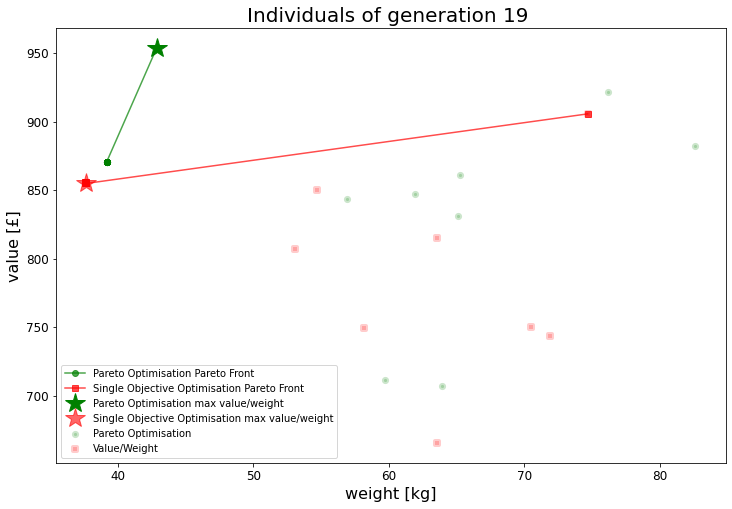

In [44]:
# visualising a selected generation

n_generation_examine = -1   # CHANGE ME!

jitter_factor = 0           # CHANGE ME! e.g, 0.001

# ----
if ('final' == n_generation_examine) or (-1 == n_generation_examine):
    n_generation_examine = n_generations - 1
    
assert n_generation_examine < n_generations
    
# indexes of this generation
idx_indvs_pareto = [idx_indv for idx_indv, indv in population_all_pareto.items() if n_generation_examine in population_all_pareto[idx_indv]['generations']]
idx_indvs_soh = [idx_indv for idx_indv, indv in population_all_soh.items() if n_generation_examine in population_all_soh[idx_indv]['generations']]

# population of this generation
population_gen_pareto = {idx_knapsack: knapsack for idx_knapsack, knapsack in population_all_pareto.items() if idx_knapsack in idx_indvs_pareto}
popuation_gen_soh     = {idx_knapsack: knapsack for idx_knapsack, knapsack in population_all_soh.items() if idx_knapsack in idx_indvs_soh}

print(f'In this generation (no. {n_generation_examine + 1})\nthe Pareto Optimisation run had {len(idx_indvs_pareto):,} individuals and the SOH Optimisation generated {len(idx_indvs_soh):,}')

indvs_pareto_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_pareto.items() if idx_knapsack in idx_indvs_pareto])
indvs_pareto_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_pareto.items() if idx_knapsack in idx_indvs_pareto])
plt.scatter(jitter(indvs_pareto_weights, scale = jitter_factor), jitter(indvs_pareto_values, scale = jitter_factor), 
            s=size, alpha=alpha, color='green', label='Pareto Optimisation', marker=None, linewidth=4)



indvs_soh_weights = np.array([knapsacks['weight'] for idx_knapsack, knapsacks in population_all_soh.items() if idx_knapsack in idx_indvs_soh])
indvs_soh_values  = np.array([knapsacks['value']  for idx_knapsack, knapsacks in population_all_soh.items() if idx_knapsack in idx_indvs_soh])
plt.scatter(jitter(indvs_soh_weights, scale = jitter_factor), jitter(indvs_soh_values, scale = jitter_factor),
            s=size, alpha=alpha, color='red', label='Value/Weight', marker='s', linewidth=4)


plot_pareto_front(population_gen_pareto, color='green', label='Pareto Optimisation Pareto Front')
plot_pareto_front(popuation_gen_soh, color='red', label='Single Objective Optimisation Pareto Front', marker='-s')

indv_ = single_objective_selector(population_gen_pareto, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='green', alpha=1, label=f'Pareto Optimisation max {heuristic}')

indv_ = single_objective_selector(popuation_gen_soh, n_select=1)
key = list(indv_.keys())[0]
plt.plot(indv_[key]['weight'], indv_[key]['value'], '*', markersize=20, color='red', alpha=0.6, label=f'Single Objective Optimisation max {heuristic}')


plt.legend(fontsize=10)  #(bbox_to_anchor=(1., 1))
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title(f'Individuals of generation {n_generation_examine} ')

# plt.xlim(*x_lim)
# plt.ylim(*y_lim)
pass

In [45]:
# examining by eye the top knapsack duplications for one generation (Single Objective Optimisation)

top = 4

print(f'Duplication of Individuals in Single Objective Optimisation in generation {n_generation_examine} (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in popuation_gen_soh.items()]).value_counts().head(top)

Duplication of Individuals in Single Objective Optimisation in generation 19 (showing top 4)


(2, 5, 7, 9, 10, 12, 15, 16, 17, 18)     32
(1, 2, 5, 7, 8, 9, 10, 12, 15, 17)        1
(5, 7, 9, 10, 11, 12, 15, 16, 17, 19)     1
(2, 4, 5, 10, 11, 12, 15, 16, 17, 18)     1
dtype: int64

In [46]:
# examining by eye the top knapsack duplications for on generation (Naive Pareto Selector)

print(f'Duplication of Individuals in Pareto Optimisation in generation {n_generation_examine} (showing top {top})')
pd.Series([tuple(sorted(knapsack['packages'])) for idx_knapsack, knapsack in population_gen_pareto.items()]).value_counts().head(top)

Duplication of Individuals in Pareto Optimisation in generation 19 (showing top 4)


(7, 9, 10, 12, 14, 15, 16, 17, 18, 19)    18
(2, 7, 9, 10, 12, 14, 15, 16, 17, 18)     14
(7, 8, 9, 10, 12, 14, 15, 16, 17, 19)      1
(2, 7, 9, 12, 13, 14, 15, 16, 18, 19)      1
dtype: int64

For completeness, there are a few more additional considerations for solving combinatorial problems with Genetic Algorithms:

* Stop criteria: you need to determine the number of iterations  
* Statistical significance: do you trust results of just one seed run or should you combine multiple? In [Pareto Front Approximation](#Pareto-Front-Approximation) we discussed niching where we saw that the resulting Pareto front of multiple seed runs is more likely to be better than each individual. This is worth contemplating, as always, within the boundaries of cost effectiveness.  

Another takeaway is the importance of visualising. Here we put a lot of focus on visualising the Objective Space and a little on the Decision Space. Depending on your project's setup you can decide how much focus to put on each to improve decision to be made.  

Also, our Objective space was 2D (`weight`, `value`). Further consideration of visualisation is required for more dimensions. E.g, 2D slices in the Objective Space using colors-grading/shapes/sizes for additional numerical/categorical dimensions.  


**Actions To Take**
- [ ] In [Knapsack Optimisation](#Knapsack-Optimisation) change to `n_generations=1` and increase to `2`, `3` etc. to see the step-by-step improvement of the Pareto front. 
- [ ] In [Knapsack Optimisation](#Knapsack-Optimisation) change by large steps `n_generations=10`, `20`, `30` etc. to see at what stage improvement of the Pareto front slows. 
- [ ] In [Knapsack Optimisation](#Knapsack-Optimisation) change  `parents_compete`. How does this impact the results? 
- [ ] In [Knapsack Optimisation](#Knapsack-Optimisation) change  `unique_indvs`. A `True` value ensures that all knapsacks are unique (`False` allows for duplicates). How does this impact the results?
- [ ] In [Knapsack Optimisation](#Knapsack-Optimisation) change the value of `seed`. Has this changed any conclusions that you derived so far?  
- [ ] In [Knapsack Optimisation](#Knapsack-Optimisation) change the value of `n_initial_population` to `100`. Is this useful?
- [ ] In [Optimisation Objective](#Optimisation-Objective) change the optimisation objective to minimising both weight and monetary value.   
This is done, e.g, by setting `objective_mode={'weight': 'min', 'value': 'min'}`.   
Try to guess in advance which knapsacks are considered Pareto Optimal!   
Try all four combinations.  
- [ ] In [Packages](#Packages) change `value_distribution_mode="squared"` to examine rules of the $value\sim weight^2$ distribution.
- [ ] Create your own distribution! Create your own custom `value_distribution_mode` in [Packages](#Packages).   


# Summary  

Congratulations! I hope that you enjoyed learning about applying Pareto Optimisation with Genetic Algorithms.  

We took a brief look at comparing results when using the commonly practiced Single Objective Optimisation.  
Results here are more likely to be suggestive than conclusive. This is mostly due to the stochastic nature of this technique.  
For robust conclusions one would have to run multiple seeds, but that is outside the scope of this notebook.  

That said, the results suggest that Single Objective Optimisation plows its way along a narrow direction, e.g maximising the `value/weight` as seen in the default setting whereas Pareto Optimisation is agnostic of this and explores all directions.   


Note that if you want to apply Pareto fronts with Genetic Algorithms, we suggest that you do not use the scripts above, but rather use as a reference for pedagogical purposes. In [Resources](#Resources) we suggest useful packages. 

# Decision Making

In the previous notebook where we applied Pareto Fronts to exhaustive search spaces we discussed what decisions may be made with the final results ([Github](https://bit.ly/pareto-front), [Google Colab](https://bit.ly/pareto-front-colab)).  

Everything said there applies to our current method of the stochastic search.   



# Resources

The following packages are useful for prototyping and contain state of the art Pareto optimal selection functions.  

* `DEAP` - evolutionary computation framework for rapid prototyping and testing of ideas.  ([site](https://deap.readthedocs.io/en/master/) )

* `pymoo` a framework that offers state of the art single- and multi-objective optimization algorithms and many more features related to multi-objective optimization such as visualization and decision making ([site](http://pymoo.org/), [github](https://github.com/msu-coinlab/pymoo/tree/6bad624cc70d12856b47c17cf0f9908a1b3653c5), [arxiv](https://arxiv.org/pdf/2002.04504.pdf) ). 

# Appendix: Visualising Decision Space

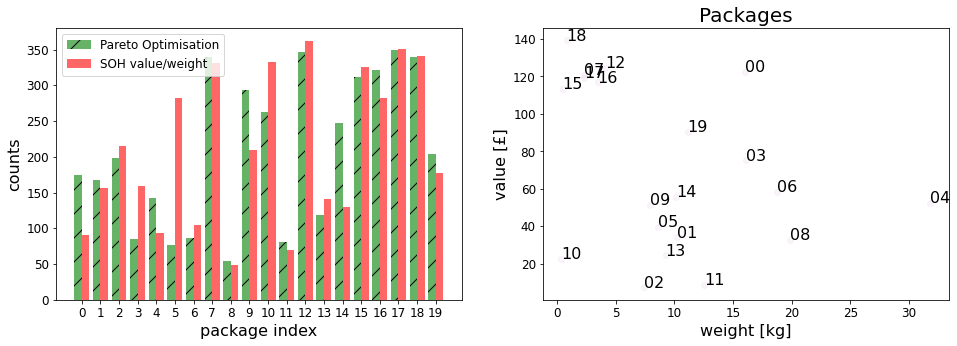

In [47]:
# visulalising the decision space

width = 0.4
alpha = 0.6

package_idxs, package_counts = np.unique([package_idx for idx_indv, indv in population_all_pareto.items() for package_idx in indv['packages']], return_counts=True)
package_counts_pareto = {package_idx: package_count for package_idx, package_count in zip(package_idxs, package_counts)}

package_idxs, package_counts = np.unique([package_idx for idx_indv, indv in population_all_soh.items() for package_idx in indv['packages']], return_counts=True)
package_counts_soh = {package_idx: package_count for package_idx, package_count in zip(package_idxs, package_counts)}


package_idxs = np.array(list(package_counts_pareto.keys()))

plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)

plt.bar(package_idxs - width/2, package_counts_pareto.values(), color='green', width=width, alpha=alpha, label='Pareto Optimisation', hatch='/')
plt.bar(package_idxs + width/2, package_counts_soh.values() , color='red', width=width, alpha=alpha, label=f'SOH {heuristic}')
plt.xticks(np.arange(len(package_idxs)), package_idxs)

plt.xlabel('package index')
plt.ylabel('counts')
plt.legend()

# ----

plt.subplot(1, 2, 2)
plt.scatter([packages[idx_package]['weight'] for idx_package in packages],
            [packages[idx_package]['value'] for idx_package in packages],
            color = 'purple', alpha=0.04
           )


for idx_package, package in packages.items():
    fontsize_ = MEDIUM_SIZE
    plt.annotate(f'{idx_package:02.0f}', xy=(package['weight'], package['value']), fontsize=fontsize_)
    
plt.xlabel('weight [kg]')
plt.ylabel('value [£]')
plt.title('Packages')


pass